# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [11]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST

As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains
images of handwritten digits. You can view the first number of examples by
changing `show_n_images`.

In [12]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(
    glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

AttributeError: 'numpy.ndarray' object has no attribute 'mask'

### CelebA

The [CelebFaces Attributes Dataset
(CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains
over 200,000 celebrity images with annotations. Since you're going to be
generating faces, you won't need the annotations. You can view the first number
of examples by changing `show_n_images`.

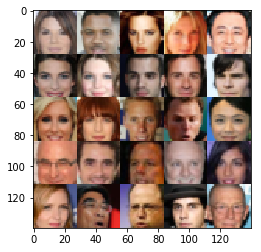

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(
    glob(os.path.join(
        data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data

Since the project's main focus is on building the GANs, we'll preprocess the
data for you. The values of the MNIST and CelebA dataset will be in the range of
-0.5 to 0.5 of 28x28 dimensional images. The CelebA images will be cropped to
remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color
channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the
CelebA images have [3 color channels (RGB color
channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).

## Build the Neural Network

You'll build the components necessary to build a GANs by implementing the
following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU

This will check to make sure you have the correct version of TensorFlow and
access to a GPU

In [1]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.5.0


Default GPU Device: /device:GPU:0


### Input

Implement the `model_inputs` function to create TF Placeholders for the Neural
Network. It should create the following placeholders:

- Real input images placeholder with rank 4 using `image_width`, `image_height`,
  and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images,
tensor of z data)

In [2]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    image_placeholder = tf.placeholder(
        shape=(None, image_width, image_height, image_channels), dtype=tf.float32)
    z_placholder = tf.placeholder(shape=(None, z_dim), dtype=tf.float32)
    learning_rate = tf.placeholder(dtype=tf.float32)
    return image_placeholder, z_placholder, learning_rate

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator

Implement `discriminator` to create a discriminator neural network that
discriminates on `images`. This function should be able to reuse the variables
in the neural network. Use
[`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope)
with a scope name of "discriminator" to allow the variables to be reused. The
function should return a tuple of (tensor output of the discriminator, tensor
logits of the discriminator).

In [15]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        # bn2 = tf.keras.layers.BatchNormalization(not reuse)(x2)
        bn2 = x2
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        # bn3 = tf.keras.layers.BatchNormalization()(x3)
        bn3 = x3
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits    


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator

Implement `generator` to generate an image using `z`. This function should be
able to reuse the variables in the neural network. Use
[`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope)
with a scope name of "generator" to allow the variables to be reused. The
function should return the generated 28 x 28 x `out_channel_dim` images.

In [16]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 4*4*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 4, 4, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 4x4x512 now

        x2 = tf.layers.conv2d_transpose(x1, 256, kernel_size=4, strides=1)
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 7x7x256 now

        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 14x14x128 now

        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        # 28x28x3 now
        out = tf.tanh(logits)
        return out
    return None


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [6]:
def model_loss(input_real, input_z, output_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, output_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [7]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [8]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [17]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model

    model_input_args = data_shape[1:] + (z_dim, )
    input_real, input_z, input_learning_rate = model_inputs(*model_input_args)
    output_chanel_dim = 3 if data_image_mode == 'RGB' else 1
    d_loss, g_loss = model_loss(input_real, input_z, output_chanel_dim)

    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)

    saver = tf.train.Saver()
    sample_z = np.random.uniform(-1, 1, size=(72, z_dim))

    samples, losses = [], []
    steps = 0

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z,
                                         input_real: batch_images})

                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % 500 == 0:
                    show_generator_output(sess, 6, input_z, output_chanel_dim,
                                          data_image_mode)
        saver.save(sess, './checkpoints/generator.ckpt')

    # with open('samples.pkl', 'wb') as f:
    #     pkl.dump(samples, f)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

In [ ]:
batch_size = 32
z_dim = 32
learning_rate = 0.0002
beta1 = 0.1

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

Epoch 1/2... Discriminator Loss: 1.4279... Generator Loss: 0.8893


Epoch 1/2... Discriminator Loss: 1.2765... Generator Loss: 0.9549


Epoch 1/2... Discriminator Loss: 1.2087... Generator Loss: 1.1719


Epoch 1/2... Discriminator Loss: 1.2455... Generator Loss: 0.8807


Epoch 1/2... Discriminator Loss: 1.2242... Generator Loss: 0.9097


Epoch 1/2... Discriminator Loss: 1.0587... Generator Loss: 1.1710


Epoch 1/2... Discriminator Loss: 1.0683... Generator Loss: 1.3241


Epoch 1/2... Discriminator Loss: 0.9227... Generator Loss: 1.7563


Epoch 1/2... Discriminator Loss: 0.8201... Generator Loss: 0.9699


Epoch 1/2... Discriminator Loss: 0.9479... Generator Loss: 2.2510


Epoch 1/2... Discriminator Loss: 0.7243... Generator Loss: 1.1890


Epoch 1/2... Discriminator Loss: 0.8543... Generator Loss: 1.3340


Epoch 1/2... Discriminator Loss: 1.5865... Generator Loss: 0.3390


Epoch 1/2... Discriminator Loss: 0.9196... Generator Loss: 0.9683


Epoch 1/2... Discriminator Loss: 1.3093... Generator Loss: 0.5379


Epoch 1/2... Discriminator Loss: 1.2046... Generator Loss: 0.6587


Epoch 1/2... Discriminator Loss: 1.2520... Generator Loss: 0.6269


Epoch 1/2... Discriminator Loss: 1.8176... Generator Loss: 0.2114


Epoch 1/2... Discriminator Loss: 1.1399... Generator Loss: 0.8015


Epoch 1/2... Discriminator Loss: 1.2919... Generator Loss: 0.7713


Epoch 1/2... Discriminator Loss: 1.2652... Generator Loss: 0.6125


Epoch 1/2... Discriminator Loss: 1.2297... Generator Loss: 0.9555


Epoch 1/2... Discriminator Loss: 1.2826... Generator Loss: 0.6758


Epoch 1/2... Discriminator Loss: 1.3107... Generator Loss: 0.6500


Epoch 1/2... Discriminator Loss: 1.3280... Generator Loss: 0.5485


Epoch 1/2... Discriminator Loss: 1.2719... Generator Loss: 0.8447


Epoch 1/2... Discriminator Loss: 1.3397... Generator Loss: 0.5512


Epoch 1/2... Discriminator Loss: 1.0683... Generator Loss: 1.0207


Epoch 1/2... Discriminator Loss: 1.6590... Generator Loss: 0.2841


Epoch 1/2... Discriminator Loss: 0.9406... Generator Loss: 0.9813


Epoch 1/2... Discriminator Loss: 1.4733... Generator Loss: 0.3826


Epoch 1/2... Discriminator Loss: 1.3156... Generator Loss: 0.5433


Epoch 1/2... Discriminator Loss: 1.2999... Generator Loss: 0.8418


Epoch 1/2... Discriminator Loss: 0.9797... Generator Loss: 2.4731


Epoch 1/2... Discriminator Loss: 1.2071... Generator Loss: 0.6937


Epoch 1/2... Discriminator Loss: 0.7280... Generator Loss: 1.9830


Epoch 1/2... Discriminator Loss: 1.2899... Generator Loss: 0.7671


Epoch 1/2... Discriminator Loss: 0.9281... Generator Loss: 1.1873


Epoch 1/2... Discriminator Loss: 0.9089... Generator Loss: 1.5746


Epoch 1/2... Discriminator Loss: 0.6919... Generator Loss: 1.7075


Epoch 1/2... Discriminator Loss: 1.1026... Generator Loss: 0.8012


Epoch 1/2... Discriminator Loss: 0.7589... Generator Loss: 1.2774


Epoch 1/2... Discriminator Loss: 1.7640... Generator Loss: 0.2325


Epoch 1/2... Discriminator Loss: 1.4312... Generator Loss: 0.3414


Epoch 1/2... Discriminator Loss: 0.8808... Generator Loss: 1.3453


Epoch 1/2... Discriminator Loss: 1.0147... Generator Loss: 1.3305


Epoch 1/2... Discriminator Loss: 0.9600... Generator Loss: 1.4463


Epoch 1/2... Discriminator Loss: 0.7302... Generator Loss: 1.3410


Epoch 1/2... Discriminator Loss: 1.6092... Generator Loss: 0.2895


AttributeError: 'numpy.ndarray' object has no attribute 'mask'

Epoch 1/2... Discriminator Loss: 1.3034... Generator Loss: 0.4730


Epoch 1/2... Discriminator Loss: 0.7921... Generator Loss: 1.2489


Epoch 1/2... Discriminator Loss: 1.1645... Generator Loss: 0.8923


Epoch 1/2... Discriminator Loss: 0.7833... Generator Loss: 2.1196


Epoch 1/2... Discriminator Loss: 1.2067... Generator Loss: 2.2034


Epoch 1/2... Discriminator Loss: 1.1220... Generator Loss: 0.7102


Epoch 1/2... Discriminator Loss: 1.4415... Generator Loss: 0.3543


Epoch 1/2... Discriminator Loss: 1.2492... Generator Loss: 0.6049


Epoch 1/2... Discriminator Loss: 1.5386... Generator Loss: 0.2970


Epoch 1/2... Discriminator Loss: 1.0347... Generator Loss: 1.2846


Epoch 1/2... Discriminator Loss: 1.3238... Generator Loss: 0.6794


Epoch 1/2... Discriminator Loss: 1.0682... Generator Loss: 1.0435


Epoch 1/2... Discriminator Loss: 1.0987... Generator Loss: 1.0821


Epoch 1/2... Discriminator Loss: 1.9431... Generator Loss: 0.1770


Epoch 1/2... Discriminator Loss: 1.2404... Generator Loss: 0.6058


Epoch 1/2... Discriminator Loss: 1.0661... Generator Loss: 1.0919


Epoch 1/2... Discriminator Loss: 1.2072... Generator Loss: 0.8188


Epoch 1/2... Discriminator Loss: 1.4948... Generator Loss: 0.3219


Epoch 1/2... Discriminator Loss: 1.0795... Generator Loss: 0.8405


Epoch 1/2... Discriminator Loss: 0.7434... Generator Loss: 2.7166


Epoch 1/2... Discriminator Loss: 1.1087... Generator Loss: 1.4647


Epoch 1/2... Discriminator Loss: 1.1969... Generator Loss: 0.5083


Epoch 1/2... Discriminator Loss: 1.5243... Generator Loss: 0.3170


Epoch 1/2... Discriminator Loss: 1.0436... Generator Loss: 1.1601


Epoch 1/2... Discriminator Loss: 1.2833... Generator Loss: 0.4345


Epoch 1/2... Discriminator Loss: 1.1093... Generator Loss: 0.5993


Epoch 1/2... Discriminator Loss: 1.0029... Generator Loss: 0.8433


Epoch 1/2... Discriminator Loss: 0.9990... Generator Loss: 1.3505


Epoch 1/2... Discriminator Loss: 1.2860... Generator Loss: 0.4326


Epoch 1/2... Discriminator Loss: 1.3254... Generator Loss: 0.6631


Epoch 1/2... Discriminator Loss: 1.0713... Generator Loss: 0.7291


Epoch 1/2... Discriminator Loss: 1.3329... Generator Loss: 0.6487


Epoch 1/2... Discriminator Loss: 0.9847... Generator Loss: 1.0087


Epoch 1/2... Discriminator Loss: 1.0074... Generator Loss: 1.2330


Epoch 1/2... Discriminator Loss: 1.0547... Generator Loss: 0.7570


Epoch 1/2... Discriminator Loss: 1.4394... Generator Loss: 0.3450


Epoch 1/2... Discriminator Loss: 0.9324... Generator Loss: 1.6794


Epoch 1/2... Discriminator Loss: 0.7550... Generator Loss: 1.8381


Epoch 1/2... Discriminator Loss: 1.3529... Generator Loss: 0.3800


Epoch 1/2... Discriminator Loss: 0.9900... Generator Loss: 1.1407


Epoch 1/2... Discriminator Loss: 1.3804... Generator Loss: 0.6455


Epoch 1/2... Discriminator Loss: 1.1401... Generator Loss: 0.7949


Epoch 1/2... Discriminator Loss: 1.5818... Generator Loss: 0.4690


Epoch 1/2... Discriminator Loss: 0.7036... Generator Loss: 2.0037


Epoch 1/2... Discriminator Loss: 0.7213... Generator Loss: 1.8014


Epoch 1/2... Discriminator Loss: 1.0335... Generator Loss: 2.0118


Epoch 1/2... Discriminator Loss: 0.8253... Generator Loss: 2.1554


Epoch 1/2... Discriminator Loss: 1.1858... Generator Loss: 0.7954


Epoch 1/2... Discriminator Loss: 0.8674... Generator Loss: 1.3896


Epoch 1/2... Discriminator Loss: 0.9473... Generator Loss: 1.0362


AttributeError: 'numpy.ndarray' object has no attribute 'mask'

Epoch 1/2... Discriminator Loss: 0.8954... Generator Loss: 1.3136


Epoch 1/2... Discriminator Loss: 0.6798... Generator Loss: 2.8842


Epoch 1/2... Discriminator Loss: 0.8798... Generator Loss: 1.2999


Epoch 1/2... Discriminator Loss: 0.7972... Generator Loss: 1.6760


Epoch 1/2... Discriminator Loss: 1.5073... Generator Loss: 0.3274


Epoch 1/2... Discriminator Loss: 0.8662... Generator Loss: 1.5108


Epoch 1/2... Discriminator Loss: 0.8625... Generator Loss: 4.7344


Epoch 1/2... Discriminator Loss: 0.9532... Generator Loss: 2.1478


Epoch 1/2... Discriminator Loss: 1.0280... Generator Loss: 0.9644


Epoch 1/2... Discriminator Loss: 0.7614... Generator Loss: 1.2253


Epoch 1/2... Discriminator Loss: 1.7432... Generator Loss: 0.2305


Epoch 1/2... Discriminator Loss: 1.8129... Generator Loss: 0.2140


Epoch 1/2... Discriminator Loss: 0.7069... Generator Loss: 1.7333


Epoch 1/2... Discriminator Loss: 0.5977... Generator Loss: 1.8830


Epoch 1/2... Discriminator Loss: 0.9467... Generator Loss: 0.9195


Epoch 1/2... Discriminator Loss: 1.2513... Generator Loss: 0.4825


Epoch 1/2... Discriminator Loss: 1.0588... Generator Loss: 0.9296


Epoch 1/2... Discriminator Loss: 1.0083... Generator Loss: 1.7298


Epoch 1/2... Discriminator Loss: 0.6990... Generator Loss: 1.8311


Epoch 1/2... Discriminator Loss: 1.0828... Generator Loss: 2.2166


Epoch 1/2... Discriminator Loss: 1.1702... Generator Loss: 0.5003


Epoch 1/2... Discriminator Loss: 1.0526... Generator Loss: 0.6129


Epoch 1/2... Discriminator Loss: 0.7471... Generator Loss: 1.3573


Epoch 1/2... Discriminator Loss: 0.6070... Generator Loss: 1.1079


Epoch 1/2... Discriminator Loss: 1.3119... Generator Loss: 2.3434


Epoch 1/2... Discriminator Loss: 1.0770... Generator Loss: 1.1033


Epoch 1/2... Discriminator Loss: 1.1887... Generator Loss: 0.7479


Epoch 1/2... Discriminator Loss: 0.8351... Generator Loss: 0.8913


Epoch 1/2... Discriminator Loss: 0.7479... Generator Loss: 2.1065


Epoch 1/2... Discriminator Loss: 0.9592... Generator Loss: 1.3184


Epoch 1/2... Discriminator Loss: 0.9018... Generator Loss: 1.6023


Epoch 1/2... Discriminator Loss: 1.1147... Generator Loss: 3.8317


Epoch 1/2... Discriminator Loss: 1.1474... Generator Loss: 0.5331


Epoch 1/2... Discriminator Loss: 1.1918... Generator Loss: 1.7256


Epoch 1/2... Discriminator Loss: 0.9746... Generator Loss: 0.7763


Epoch 1/2... Discriminator Loss: 0.8570... Generator Loss: 0.8758


Epoch 1/2... Discriminator Loss: 0.9761... Generator Loss: 2.2590


Epoch 1/2... Discriminator Loss: 1.0013... Generator Loss: 1.2924


Epoch 1/2... Discriminator Loss: 0.9841... Generator Loss: 0.9386


Epoch 1/2... Discriminator Loss: 1.2692... Generator Loss: 1.9430


Epoch 1/2... Discriminator Loss: 1.4237... Generator Loss: 0.3447


Epoch 1/2... Discriminator Loss: 1.0512... Generator Loss: 0.8713


Epoch 1/2... Discriminator Loss: 0.9092... Generator Loss: 1.0599


Epoch 1/2... Discriminator Loss: 0.9763... Generator Loss: 1.0325


Epoch 1/2... Discriminator Loss: 0.8613... Generator Loss: 0.9708


Epoch 1/2... Discriminator Loss: 0.7890... Generator Loss: 1.1669


Epoch 1/2... Discriminator Loss: 0.8999... Generator Loss: 1.3944


Epoch 1/2... Discriminator Loss: 0.3340... Generator Loss: 1.8913


Epoch 1/2... Discriminator Loss: 1.1279... Generator Loss: 0.6988


Epoch 1/2... Discriminator Loss: 1.1680... Generator Loss: 0.4793


AttributeError: 'numpy.ndarray' object has no attribute 'mask'

Epoch 1/2... Discriminator Loss: 1.0763... Generator Loss: 1.0221


Epoch 1/2... Discriminator Loss: 1.2386... Generator Loss: 0.4488


Epoch 1/2... Discriminator Loss: 1.0884... Generator Loss: 0.5138


Epoch 1/2... Discriminator Loss: 1.0278... Generator Loss: 0.6947


Epoch 1/2... Discriminator Loss: 0.5465... Generator Loss: 1.2825


Epoch 1/2... Discriminator Loss: 0.8053... Generator Loss: 1.1548


Epoch 1/2... Discriminator Loss: 0.8904... Generator Loss: 1.0231


Epoch 1/2... Discriminator Loss: 0.7628... Generator Loss: 1.3196


Epoch 1/2... Discriminator Loss: 0.9537... Generator Loss: 1.2370


Epoch 1/2... Discriminator Loss: 1.4180... Generator Loss: 2.5001


Epoch 1/2... Discriminator Loss: 0.9129... Generator Loss: 0.8376


Epoch 1/2... Discriminator Loss: 0.9602... Generator Loss: 0.8804


Epoch 1/2... Discriminator Loss: 0.9079... Generator Loss: 0.7518


Epoch 1/2... Discriminator Loss: 0.8261... Generator Loss: 0.6985


Epoch 1/2... Discriminator Loss: 1.0961... Generator Loss: 0.9487


Epoch 1/2... Discriminator Loss: 0.9487... Generator Loss: 0.8579


Epoch 1/2... Discriminator Loss: 1.1287... Generator Loss: 0.4807


Epoch 1/2... Discriminator Loss: 1.8686... Generator Loss: 0.1903


Epoch 1/2... Discriminator Loss: 0.8956... Generator Loss: 1.2121


Epoch 1/2... Discriminator Loss: 0.9989... Generator Loss: 1.3103


Epoch 1/2... Discriminator Loss: 1.0546... Generator Loss: 0.6121


Epoch 1/2... Discriminator Loss: 1.0636... Generator Loss: 0.5883


Epoch 1/2... Discriminator Loss: 1.8660... Generator Loss: 0.1910


Epoch 1/2... Discriminator Loss: 1.6781... Generator Loss: 0.2470


Epoch 1/2... Discriminator Loss: 0.8536... Generator Loss: 0.8885


Epoch 1/2... Discriminator Loss: 0.9069... Generator Loss: 1.0780


Epoch 1/2... Discriminator Loss: 1.0020... Generator Loss: 0.8821


Epoch 1/2... Discriminator Loss: 1.3756... Generator Loss: 0.3577


Epoch 1/2... Discriminator Loss: 1.1902... Generator Loss: 2.6394


Epoch 1/2... Discriminator Loss: 0.9177... Generator Loss: 6.4723


Epoch 1/2... Discriminator Loss: 0.8502... Generator Loss: 1.8819


Epoch 1/2... Discriminator Loss: 0.8828... Generator Loss: 1.8425


Epoch 1/2... Discriminator Loss: 1.2372... Generator Loss: 1.8364


Epoch 1/2... Discriminator Loss: 1.1318... Generator Loss: 0.9918


Epoch 1/2... Discriminator Loss: 0.6959... Generator Loss: 4.6021


Epoch 1/2... Discriminator Loss: 1.4200... Generator Loss: 0.3276


Epoch 1/2... Discriminator Loss: 0.4146... Generator Loss: 1.2804


Epoch 2/2... Discriminator Loss: 1.4711... Generator Loss: 0.3198


Epoch 2/2... Discriminator Loss: 1.1033... Generator Loss: 0.7299


Epoch 2/2... Discriminator Loss: 1.0004... Generator Loss: 1.0458


Epoch 2/2... Discriminator Loss: 0.8065... Generator Loss: 1.3831


Epoch 2/2... Discriminator Loss: 0.8484... Generator Loss: 2.1172


Epoch 2/2... Discriminator Loss: 0.8176... Generator Loss: 2.2025


Epoch 2/2... Discriminator Loss: 0.7263... Generator Loss: 0.9169


Epoch 2/2... Discriminator Loss: 1.0247... Generator Loss: 0.6112


Epoch 2/2... Discriminator Loss: 0.9978... Generator Loss: 0.7020


Epoch 2/2... Discriminator Loss: 0.8975... Generator Loss: 1.5439


Epoch 2/2... Discriminator Loss: 1.3110... Generator Loss: 2.7645


Epoch 2/2... Discriminator Loss: 0.6399... Generator Loss: 1.9508


Epoch 2/2... Discriminator Loss: 0.6721... Generator Loss: 1.6261


AttributeError: 'numpy.ndarray' object has no attribute 'mask'

Epoch 2/2... Discriminator Loss: 0.9226... Generator Loss: 1.8224


Epoch 2/2... Discriminator Loss: 0.6658... Generator Loss: 1.3079


Epoch 2/2... Discriminator Loss: 1.3088... Generator Loss: 0.6066


Epoch 2/2... Discriminator Loss: 0.6451... Generator Loss: 1.7837


Epoch 2/2... Discriminator Loss: 0.8681... Generator Loss: 1.3501


Epoch 2/2... Discriminator Loss: 0.8703... Generator Loss: 0.8935


Epoch 2/2... Discriminator Loss: 1.1760... Generator Loss: 0.7254


Epoch 2/2... Discriminator Loss: 1.5660... Generator Loss: 0.2692


Epoch 2/2... Discriminator Loss: 0.8819... Generator Loss: 1.6772


Epoch 2/2... Discriminator Loss: 0.7018... Generator Loss: 1.2939


Epoch 2/2... Discriminator Loss: 0.9692... Generator Loss: 1.5759


Epoch 2/2... Discriminator Loss: 1.4187... Generator Loss: 2.1671


Epoch 2/2... Discriminator Loss: 1.0100... Generator Loss: 1.9821


Epoch 2/2... Discriminator Loss: 0.9626... Generator Loss: 1.2376


KeyboardInterrupt: 

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.2106... Generator Loss: 1.0156


Epoch 1/1... Discriminator Loss: 1.1192... Generator Loss: 1.2854


Epoch 1/1... Discriminator Loss: 1.3121... Generator Loss: 0.9679


Epoch 1/1... Discriminator Loss: 1.2793... Generator Loss: 0.7612


Epoch 1/1... Discriminator Loss: 1.0183... Generator Loss: 0.9351


Epoch 1/1... Discriminator Loss: 1.3589... Generator Loss: 0.5775


Epoch 1/1... Discriminator Loss: 1.4675... Generator Loss: 0.5194


Epoch 1/1... Discriminator Loss: 1.3016... Generator Loss: 0.5852


Epoch 1/1... Discriminator Loss: 1.2749... Generator Loss: 0.5781


Epoch 1/1... Discriminator Loss: 1.3592... Generator Loss: 0.6621


Epoch 1/1... Discriminator Loss: 1.4752... Generator Loss: 0.5767


Epoch 1/1... Discriminator Loss: 1.4747... Generator Loss: 0.4360


Epoch 1/1... Discriminator Loss: 1.4516... Generator Loss: 0.4659


Epoch 1/1... Discriminator Loss: 1.0926... Generator Loss: 1.1827


Epoch 1/1... Discriminator Loss: 0.9908... Generator Loss: 1.0835


Epoch 1/1... Discriminator Loss: 0.5282... Generator Loss: 1.3500


Epoch 1/1... Discriminator Loss: 0.9063... Generator Loss: 0.7368


Epoch 1/1... Discriminator Loss: 1.0908... Generator Loss: 1.0320


Epoch 1/1... Discriminator Loss: 0.4153... Generator Loss: 2.0122


Epoch 1/1... Discriminator Loss: 2.5801... Generator Loss: 0.0877


Epoch 1/1... Discriminator Loss: 0.2974... Generator Loss: 2.2361


Epoch 1/1... Discriminator Loss: 0.7702... Generator Loss: 1.2730


Epoch 1/1... Discriminator Loss: 1.2620... Generator Loss: 0.4695


Epoch 1/1... Discriminator Loss: 0.7314... Generator Loss: 1.0511


Epoch 1/1... Discriminator Loss: 1.8245... Generator Loss: 0.2376


Epoch 1/1... Discriminator Loss: 0.3402... Generator Loss: 2.9587


Epoch 1/1... Discriminator Loss: 0.3081... Generator Loss: 2.0074


Epoch 1/1... Discriminator Loss: 0.8228... Generator Loss: 1.1248


Epoch 1/1... Discriminator Loss: 1.1366... Generator Loss: 1.0368


Epoch 1/1... Discriminator Loss: 1.2033... Generator Loss: 0.9328


Epoch 1/1... Discriminator Loss: 0.6588... Generator Loss: 2.1512


Epoch 1/1... Discriminator Loss: 0.6599... Generator Loss: 3.2902


Epoch 1/1... Discriminator Loss: 0.8072... Generator Loss: 2.9225


Epoch 1/1... Discriminator Loss: 1.2180... Generator Loss: 1.6442


Epoch 1/1... Discriminator Loss: 0.8775... Generator Loss: 1.3225


Epoch 1/1... Discriminator Loss: 0.7156... Generator Loss: 1.2650


Epoch 1/1... Discriminator Loss: 0.7362... Generator Loss: 0.9180


Epoch 1/1... Discriminator Loss: 0.7891... Generator Loss: 1.7186


Epoch 1/1... Discriminator Loss: 1.5861... Generator Loss: 0.2992


Epoch 1/1... Discriminator Loss: 0.7156... Generator Loss: 1.1862


Epoch 1/1... Discriminator Loss: 0.8309... Generator Loss: 1.4526


Epoch 1/1... Discriminator Loss: 0.5412... Generator Loss: 1.4022


Epoch 1/1... Discriminator Loss: 0.7160... Generator Loss: 1.4047


Epoch 1/1... Discriminator Loss: 0.4045... Generator Loss: 2.9585


Epoch 1/1... Discriminator Loss: 1.0382... Generator Loss: 1.4143


Epoch 1/1... Discriminator Loss: 1.1727... Generator Loss: 1.0158


Epoch 1/1... Discriminator Loss: 1.0592... Generator Loss: 0.9198


Epoch 1/1... Discriminator Loss: 1.0260... Generator Loss: 1.1219


Epoch 1/1... Discriminator Loss: 0.8339... Generator Loss: 0.9456


Epoch 1/1... Discriminator Loss: 0.7415... Generator Loss: 1.5242


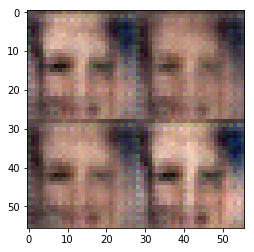

Epoch 1/1... Discriminator Loss: 0.7329... Generator Loss: 1.6792


Epoch 1/1... Discriminator Loss: 0.8765... Generator Loss: 1.3194


Epoch 1/1... Discriminator Loss: 0.7883... Generator Loss: 1.5183


Epoch 1/1... Discriminator Loss: 1.1207... Generator Loss: 0.7326


Epoch 1/1... Discriminator Loss: 1.0106... Generator Loss: 1.1304


Epoch 1/1... Discriminator Loss: 1.1477... Generator Loss: 0.8065


Epoch 1/1... Discriminator Loss: 0.6123... Generator Loss: 2.3531


Epoch 1/1... Discriminator Loss: 0.6238... Generator Loss: 1.9861


Epoch 1/1... Discriminator Loss: 1.5623... Generator Loss: 0.3878


Epoch 1/1... Discriminator Loss: 1.2227... Generator Loss: 1.7446


Epoch 1/1... Discriminator Loss: 0.9910... Generator Loss: 1.6935


Epoch 1/1... Discriminator Loss: 1.0125... Generator Loss: 2.0308


Epoch 1/1... Discriminator Loss: 1.1253... Generator Loss: 0.7844


Epoch 1/1... Discriminator Loss: 0.8627... Generator Loss: 1.0205


Epoch 1/1... Discriminator Loss: 0.7549... Generator Loss: 1.2738


Epoch 1/1... Discriminator Loss: 0.9523... Generator Loss: 0.9701


Epoch 1/1... Discriminator Loss: 0.5228... Generator Loss: 2.0617


Epoch 1/1... Discriminator Loss: 1.2769... Generator Loss: 2.0869


Epoch 1/1... Discriminator Loss: 1.1099... Generator Loss: 0.7420


Epoch 1/1... Discriminator Loss: 0.7597... Generator Loss: 1.4521


Epoch 1/1... Discriminator Loss: 1.0304... Generator Loss: 3.0679


Epoch 1/1... Discriminator Loss: 0.9427... Generator Loss: 0.7759


Epoch 1/1... Discriminator Loss: 0.8349... Generator Loss: 2.1331


Epoch 1/1... Discriminator Loss: 1.6325... Generator Loss: 0.3479


Epoch 1/1... Discriminator Loss: 0.6240... Generator Loss: 4.5219


Epoch 1/1... Discriminator Loss: 1.0640... Generator Loss: 0.9066


Epoch 1/1... Discriminator Loss: 1.0222... Generator Loss: 1.9656


Epoch 1/1... Discriminator Loss: 1.5774... Generator Loss: 0.6551


Epoch 1/1... Discriminator Loss: 1.1281... Generator Loss: 0.7607


Epoch 1/1... Discriminator Loss: 0.8450... Generator Loss: 1.2034


Epoch 1/1... Discriminator Loss: 0.9302... Generator Loss: 1.3615


Epoch 1/1... Discriminator Loss: 0.9073... Generator Loss: 0.9577


Epoch 1/1... Discriminator Loss: 1.2220... Generator Loss: 0.5928


Epoch 1/1... Discriminator Loss: 1.0272... Generator Loss: 1.4269


Epoch 1/1... Discriminator Loss: 0.9314... Generator Loss: 0.9025


Epoch 1/1... Discriminator Loss: 0.9399... Generator Loss: 1.9923


Epoch 1/1... Discriminator Loss: 1.1113... Generator Loss: 1.3241


Epoch 1/1... Discriminator Loss: 0.9422... Generator Loss: 3.2339


Epoch 1/1... Discriminator Loss: 0.9364... Generator Loss: 1.1922


Epoch 1/1... Discriminator Loss: 0.7869... Generator Loss: 1.8963


Epoch 1/1... Discriminator Loss: 0.6986... Generator Loss: 2.3167


Epoch 1/1... Discriminator Loss: 0.8010... Generator Loss: 2.2061


Epoch 1/1... Discriminator Loss: 0.5386... Generator Loss: 1.9419


Epoch 1/1... Discriminator Loss: 1.2492... Generator Loss: 2.1101


Epoch 1/1... Discriminator Loss: 0.9396... Generator Loss: 0.6953


Epoch 1/1... Discriminator Loss: 0.9925... Generator Loss: 0.7486


Epoch 1/1... Discriminator Loss: 0.5400... Generator Loss: 1.8693


Epoch 1/1... Discriminator Loss: 0.8822... Generator Loss: 2.1223


Epoch 1/1... Discriminator Loss: 0.5715... Generator Loss: 2.1315


Epoch 1/1... Discriminator Loss: 0.7917... Generator Loss: 2.3985


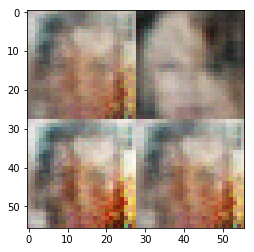

Epoch 1/1... Discriminator Loss: 0.7077... Generator Loss: 1.5747


Epoch 1/1... Discriminator Loss: 0.4759... Generator Loss: 3.0137


Epoch 1/1... Discriminator Loss: 1.3299... Generator Loss: 0.8182


Epoch 1/1... Discriminator Loss: 1.2311... Generator Loss: 0.7591


Epoch 1/1... Discriminator Loss: 0.6212... Generator Loss: 3.3914


Epoch 1/1... Discriminator Loss: 0.7572... Generator Loss: 1.4377


Epoch 1/1... Discriminator Loss: 0.8895... Generator Loss: 4.8445


Epoch 1/1... Discriminator Loss: 0.3556... Generator Loss: 4.5564


Epoch 1/1... Discriminator Loss: 0.6120... Generator Loss: 6.4116


Epoch 1/1... Discriminator Loss: 0.6964... Generator Loss: 2.4417


Epoch 1/1... Discriminator Loss: 0.6950... Generator Loss: 2.1076


Epoch 1/1... Discriminator Loss: 0.7710... Generator Loss: 1.0856


Epoch 1/1... Discriminator Loss: 0.8664... Generator Loss: 1.7508


Epoch 1/1... Discriminator Loss: 0.6969... Generator Loss: 3.1532


Epoch 1/1... Discriminator Loss: 0.7853... Generator Loss: 1.7394


Epoch 1/1... Discriminator Loss: 0.5413... Generator Loss: 5.1830


Epoch 1/1... Discriminator Loss: 0.8659... Generator Loss: 1.2545


Epoch 1/1... Discriminator Loss: 0.6502... Generator Loss: 2.8016


Epoch 1/1... Discriminator Loss: 0.8209... Generator Loss: 2.1370


Epoch 1/1... Discriminator Loss: 0.7548... Generator Loss: 2.5955


Epoch 1/1... Discriminator Loss: 0.5884... Generator Loss: 1.9245


Epoch 1/1... Discriminator Loss: 0.6388... Generator Loss: 2.3784


Epoch 1/1... Discriminator Loss: 0.8244... Generator Loss: 2.3073


Epoch 1/1... Discriminator Loss: 1.0870... Generator Loss: 0.9509


Epoch 1/1... Discriminator Loss: 0.3201... Generator Loss: 4.4062


Epoch 1/1... Discriminator Loss: 0.8487... Generator Loss: 2.6919


Epoch 1/1... Discriminator Loss: 0.7742... Generator Loss: 2.8130


Epoch 1/1... Discriminator Loss: 0.5340... Generator Loss: 4.0761


Epoch 1/1... Discriminator Loss: 0.5271... Generator Loss: 2.2156


Epoch 1/1... Discriminator Loss: 1.0356... Generator Loss: 0.7285


Epoch 1/1... Discriminator Loss: 0.7191... Generator Loss: 3.1892


Epoch 1/1... Discriminator Loss: 0.9336... Generator Loss: 2.1499


Epoch 1/1... Discriminator Loss: 0.4045... Generator Loss: 4.3527


Epoch 1/1... Discriminator Loss: 0.4068... Generator Loss: 4.8506


Epoch 1/1... Discriminator Loss: 0.9814... Generator Loss: 1.1682


Epoch 1/1... Discriminator Loss: 0.8257... Generator Loss: 1.3280


Epoch 1/1... Discriminator Loss: 0.9512... Generator Loss: 1.5130


Epoch 1/1... Discriminator Loss: 1.0399... Generator Loss: 1.2907


Epoch 1/1... Discriminator Loss: 0.9266... Generator Loss: 1.2544


Epoch 1/1... Discriminator Loss: 0.6139... Generator Loss: 3.9745


Epoch 1/1... Discriminator Loss: 0.8003... Generator Loss: 1.2467


Epoch 1/1... Discriminator Loss: 0.5560... Generator Loss: 1.7621


Epoch 1/1... Discriminator Loss: 0.8751... Generator Loss: 1.9253


Epoch 1/1... Discriminator Loss: 0.8847... Generator Loss: 1.6545


Epoch 1/1... Discriminator Loss: 0.6773... Generator Loss: 1.7379


Epoch 1/1... Discriminator Loss: 0.8842... Generator Loss: 1.2678


Epoch 1/1... Discriminator Loss: 0.5944... Generator Loss: 3.8521


Epoch 1/1... Discriminator Loss: 0.5751... Generator Loss: 2.4168


Epoch 1/1... Discriminator Loss: 0.9836... Generator Loss: 1.0060


Epoch 1/1... Discriminator Loss: 0.8984... Generator Loss: 1.7138


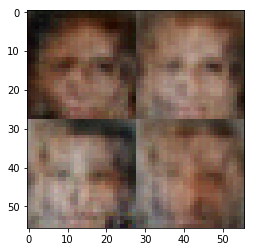

Epoch 1/1... Discriminator Loss: 0.7932... Generator Loss: 3.0653


Epoch 1/1... Discriminator Loss: 0.7718... Generator Loss: 2.1095


Epoch 1/1... Discriminator Loss: 0.5084... Generator Loss: 4.3622


Epoch 1/1... Discriminator Loss: 1.7074... Generator Loss: 6.3037


Epoch 1/1... Discriminator Loss: 0.5561... Generator Loss: 2.1522


Epoch 1/1... Discriminator Loss: 0.8039... Generator Loss: 4.3760


Epoch 1/1... Discriminator Loss: 0.5476... Generator Loss: 2.5941


Epoch 1/1... Discriminator Loss: 0.5529... Generator Loss: 1.7330


Epoch 1/1... Discriminator Loss: 1.0226... Generator Loss: 1.7128


Epoch 1/1... Discriminator Loss: 1.0596... Generator Loss: 1.9619


Epoch 1/1... Discriminator Loss: 0.7791... Generator Loss: 1.8266


Epoch 1/1... Discriminator Loss: 0.3820... Generator Loss: 7.2099


Epoch 1/1... Discriminator Loss: 0.8219... Generator Loss: 1.3504


Epoch 1/1... Discriminator Loss: 0.9298... Generator Loss: 1.4963


Epoch 1/1... Discriminator Loss: 0.6750... Generator Loss: 2.2685


Epoch 1/1... Discriminator Loss: 0.7997... Generator Loss: 1.5133


Epoch 1/1... Discriminator Loss: 0.8583... Generator Loss: 1.7381


Epoch 1/1... Discriminator Loss: 1.3029... Generator Loss: 3.8484


Epoch 1/1... Discriminator Loss: 0.6100... Generator Loss: 2.6707


Epoch 1/1... Discriminator Loss: 0.7291... Generator Loss: 5.2334


Epoch 1/1... Discriminator Loss: 1.1178... Generator Loss: 1.3689


Epoch 1/1... Discriminator Loss: 1.0712... Generator Loss: 1.6416


Epoch 1/1... Discriminator Loss: 0.8835... Generator Loss: 1.9806


Epoch 1/1... Discriminator Loss: 0.4660... Generator Loss: 2.0888


Epoch 1/1... Discriminator Loss: 0.7373... Generator Loss: 1.4897


Epoch 1/1... Discriminator Loss: 1.0372... Generator Loss: 1.0486


Epoch 1/1... Discriminator Loss: 0.7062... Generator Loss: 1.6045


Epoch 1/1... Discriminator Loss: 0.8646... Generator Loss: 1.8205


Epoch 1/1... Discriminator Loss: 0.7721... Generator Loss: 1.5066


Epoch 1/1... Discriminator Loss: 0.5607... Generator Loss: 3.5400


Epoch 1/1... Discriminator Loss: 0.6708... Generator Loss: 2.2050


Epoch 1/1... Discriminator Loss: 0.7522... Generator Loss: 2.5701


Epoch 1/1... Discriminator Loss: 0.8118... Generator Loss: 1.8610


Epoch 1/1... Discriminator Loss: 0.7401... Generator Loss: 4.4311


Epoch 1/1... Discriminator Loss: 0.5890... Generator Loss: 2.6102


Epoch 1/1... Discriminator Loss: 0.4226... Generator Loss: 4.7679


Epoch 1/1... Discriminator Loss: 0.9653... Generator Loss: 1.2315


Epoch 1/1... Discriminator Loss: 0.7306... Generator Loss: 1.5818


Epoch 1/1... Discriminator Loss: 0.7904... Generator Loss: 2.6792


Epoch 1/1... Discriminator Loss: 0.5443... Generator Loss: 6.3125


Epoch 1/1... Discriminator Loss: 0.5001... Generator Loss: 2.2512


Epoch 1/1... Discriminator Loss: 0.6784... Generator Loss: 2.2554


Epoch 1/1... Discriminator Loss: 1.2188... Generator Loss: 0.8567


Epoch 1/1... Discriminator Loss: 0.5616... Generator Loss: 3.3391


Epoch 1/1... Discriminator Loss: 0.5514... Generator Loss: 3.4678


Epoch 1/1... Discriminator Loss: 0.7399... Generator Loss: 4.1752


Epoch 1/1... Discriminator Loss: 0.8694... Generator Loss: 1.8800


Epoch 1/1... Discriminator Loss: 0.6931... Generator Loss: 2.1507


Epoch 1/1... Discriminator Loss: 0.6297... Generator Loss: 4.1714


Epoch 1/1... Discriminator Loss: 0.7888... Generator Loss: 2.9716


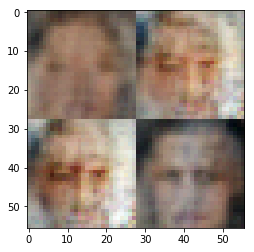

Epoch 1/1... Discriminator Loss: 0.7063... Generator Loss: 1.4679


Epoch 1/1... Discriminator Loss: 0.4201... Generator Loss: 5.4514


Epoch 1/1... Discriminator Loss: 0.6592... Generator Loss: 1.8371


Epoch 1/1... Discriminator Loss: 0.9381... Generator Loss: 1.3667


Epoch 1/1... Discriminator Loss: 1.1032... Generator Loss: 1.0250


Epoch 1/1... Discriminator Loss: 0.6569... Generator Loss: 3.0402


Epoch 1/1... Discriminator Loss: 1.0333... Generator Loss: 1.5567


Epoch 1/1... Discriminator Loss: 0.5085... Generator Loss: 3.6265


Epoch 1/1... Discriminator Loss: 1.0168... Generator Loss: 3.3946


Epoch 1/1... Discriminator Loss: 0.8462... Generator Loss: 2.2345


Epoch 1/1... Discriminator Loss: 1.0293... Generator Loss: 1.0085


Epoch 1/1... Discriminator Loss: 0.9059... Generator Loss: 3.9937


Epoch 1/1... Discriminator Loss: 0.6021... Generator Loss: 2.3759


Epoch 1/1... Discriminator Loss: 0.3736... Generator Loss: 3.5719


Epoch 1/1... Discriminator Loss: 0.9605... Generator Loss: 1.3559


Epoch 1/1... Discriminator Loss: 1.0533... Generator Loss: 1.1928


Epoch 1/1... Discriminator Loss: 0.8520... Generator Loss: 2.9882


Epoch 1/1... Discriminator Loss: 0.7417... Generator Loss: 1.2689


Epoch 1/1... Discriminator Loss: 0.4762... Generator Loss: 4.0099


Epoch 1/1... Discriminator Loss: 0.7383... Generator Loss: 1.7360


Epoch 1/1... Discriminator Loss: 0.2592... Generator Loss: 4.6304


Epoch 1/1... Discriminator Loss: 0.6818... Generator Loss: 2.4170


Epoch 1/1... Discriminator Loss: 1.1372... Generator Loss: 0.9805


Epoch 1/1... Discriminator Loss: 0.8708... Generator Loss: 1.2575


Epoch 1/1... Discriminator Loss: 1.0324... Generator Loss: 1.2596


Epoch 1/1... Discriminator Loss: 0.8792... Generator Loss: 1.7746


Epoch 1/1... Discriminator Loss: 0.6481... Generator Loss: 3.0034


Epoch 1/1... Discriminator Loss: 0.8901... Generator Loss: 1.4513


Epoch 1/1... Discriminator Loss: 0.7626... Generator Loss: 1.7899


Epoch 1/1... Discriminator Loss: 0.8845... Generator Loss: 1.1629


Epoch 1/1... Discriminator Loss: 0.7928... Generator Loss: 2.1263


Epoch 1/1... Discriminator Loss: 0.7133... Generator Loss: 2.2869


Epoch 1/1... Discriminator Loss: 0.5988... Generator Loss: 3.1780


Epoch 1/1... Discriminator Loss: 0.4766... Generator Loss: 4.8703


Epoch 1/1... Discriminator Loss: 0.2647... Generator Loss: 3.6980


Epoch 1/1... Discriminator Loss: 0.7604... Generator Loss: 2.5072


Epoch 1/1... Discriminator Loss: 0.8468... Generator Loss: 2.0462


Epoch 1/1... Discriminator Loss: 0.7333... Generator Loss: 1.7834


Epoch 1/1... Discriminator Loss: 0.1500... Generator Loss: 5.4702


Epoch 1/1... Discriminator Loss: 0.9770... Generator Loss: 4.7226


Epoch 1/1... Discriminator Loss: 0.7457... Generator Loss: 1.7661


Epoch 1/1... Discriminator Loss: 0.1097... Generator Loss: 8.5164


Epoch 1/1... Discriminator Loss: 0.7346... Generator Loss: 3.3889


Epoch 1/1... Discriminator Loss: 0.1752... Generator Loss: 9.5429


Epoch 1/1... Discriminator Loss: 0.8432... Generator Loss: 1.7165


Epoch 1/1... Discriminator Loss: 0.7554... Generator Loss: 1.0221


Epoch 1/1... Discriminator Loss: 0.9228... Generator Loss: 1.1201


Epoch 1/1... Discriminator Loss: 0.9039... Generator Loss: 1.6787


Epoch 1/1... Discriminator Loss: 0.3464... Generator Loss: 3.3005


Epoch 1/1... Discriminator Loss: 0.7833... Generator Loss: 1.3605


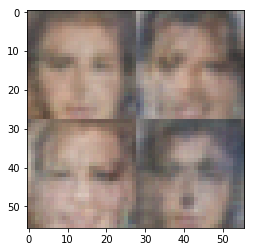

Epoch 1/1... Discriminator Loss: 0.5813... Generator Loss: 3.8439


Epoch 1/1... Discriminator Loss: 0.7843... Generator Loss: 1.6160


Epoch 1/1... Discriminator Loss: 0.7690... Generator Loss: 1.4399


Epoch 1/1... Discriminator Loss: 0.6933... Generator Loss: 6.4784


Epoch 1/1... Discriminator Loss: 1.1451... Generator Loss: 1.2933


Epoch 1/1... Discriminator Loss: 0.5572... Generator Loss: 3.9402


Epoch 1/1... Discriminator Loss: 0.2038... Generator Loss: 14.8786


Epoch 1/1... Discriminator Loss: 0.8655... Generator Loss: 2.4953


Epoch 1/1... Discriminator Loss: 0.4481... Generator Loss: 5.0461


Epoch 1/1... Discriminator Loss: 0.7519... Generator Loss: 1.7464


Epoch 1/1... Discriminator Loss: 0.9340... Generator Loss: 1.0021


Epoch 1/1... Discriminator Loss: 0.7427... Generator Loss: 1.9947


Epoch 1/1... Discriminator Loss: 0.7465... Generator Loss: 1.9639


Epoch 1/1... Discriminator Loss: 0.8374... Generator Loss: 1.1572


Epoch 1/1... Discriminator Loss: 1.2827... Generator Loss: 1.6650


Epoch 1/1... Discriminator Loss: 0.6699... Generator Loss: 5.1440


Epoch 1/1... Discriminator Loss: 0.9513... Generator Loss: 1.6096


Epoch 1/1... Discriminator Loss: 0.8951... Generator Loss: 1.4699


Epoch 1/1... Discriminator Loss: 0.8192... Generator Loss: 2.4528


Epoch 1/1... Discriminator Loss: 0.9919... Generator Loss: 1.3840


Epoch 1/1... Discriminator Loss: 1.0403... Generator Loss: 2.7229


Epoch 1/1... Discriminator Loss: 1.0048... Generator Loss: 1.0949


Epoch 1/1... Discriminator Loss: 0.8358... Generator Loss: 2.5910


Epoch 1/1... Discriminator Loss: 0.6659... Generator Loss: 4.5153


Epoch 1/1... Discriminator Loss: 0.8490... Generator Loss: 2.0586


Epoch 1/1... Discriminator Loss: 0.9570... Generator Loss: 2.6207


Epoch 1/1... Discriminator Loss: 0.5478... Generator Loss: 2.3271


Epoch 1/1... Discriminator Loss: 0.7426... Generator Loss: 2.0308


Epoch 1/1... Discriminator Loss: 1.0385... Generator Loss: 2.8264


Epoch 1/1... Discriminator Loss: 0.9389... Generator Loss: 1.4841


Epoch 1/1... Discriminator Loss: 0.6931... Generator Loss: 2.5181


Epoch 1/1... Discriminator Loss: 0.9345... Generator Loss: 1.4651


Epoch 1/1... Discriminator Loss: 0.7127... Generator Loss: 2.3589


Epoch 1/1... Discriminator Loss: 0.7585... Generator Loss: 2.0334


Epoch 1/1... Discriminator Loss: 1.0689... Generator Loss: 1.3618


Epoch 1/1... Discriminator Loss: 0.6475... Generator Loss: 2.3748


Epoch 1/1... Discriminator Loss: 1.0523... Generator Loss: 2.3267


Epoch 1/1... Discriminator Loss: 1.0265... Generator Loss: 1.0940


Epoch 1/1... Discriminator Loss: 0.8941... Generator Loss: 1.7960


Epoch 1/1... Discriminator Loss: 0.8504... Generator Loss: 3.1326


Epoch 1/1... Discriminator Loss: 0.6688... Generator Loss: 2.1364


Epoch 1/1... Discriminator Loss: 0.9615... Generator Loss: 1.2567


Epoch 1/1... Discriminator Loss: 0.8149... Generator Loss: 1.2847


Epoch 1/1... Discriminator Loss: 0.7012... Generator Loss: 4.6775


Epoch 1/1... Discriminator Loss: 1.3658... Generator Loss: 0.8928


Epoch 1/1... Discriminator Loss: 0.7599... Generator Loss: 2.1298


Epoch 1/1... Discriminator Loss: 0.9064... Generator Loss: 1.5961


Epoch 1/1... Discriminator Loss: 0.8443... Generator Loss: 1.2005


Epoch 1/1... Discriminator Loss: 0.1722... Generator Loss: 8.8727


Epoch 1/1... Discriminator Loss: 0.7543... Generator Loss: 2.5586


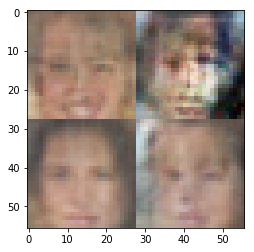

Epoch 1/1... Discriminator Loss: 0.7463... Generator Loss: 2.9038


Epoch 1/1... Discriminator Loss: 1.2312... Generator Loss: 0.8011


Epoch 1/1... Discriminator Loss: 1.2063... Generator Loss: 0.5183


Epoch 1/1... Discriminator Loss: 0.6764... Generator Loss: 2.7260


Epoch 1/1... Discriminator Loss: 0.9496... Generator Loss: 1.4143


Epoch 1/1... Discriminator Loss: 0.7239... Generator Loss: 1.8315


Epoch 1/1... Discriminator Loss: 0.7882... Generator Loss: 1.8415


Epoch 1/1... Discriminator Loss: 0.9579... Generator Loss: 1.1206


Epoch 1/1... Discriminator Loss: 0.6175... Generator Loss: 3.1753


Epoch 1/1... Discriminator Loss: 0.7076... Generator Loss: 2.0775


Epoch 1/1... Discriminator Loss: 1.0494... Generator Loss: 2.0414


Epoch 1/1... Discriminator Loss: 0.8754... Generator Loss: 1.6830


Epoch 1/1... Discriminator Loss: 0.4327... Generator Loss: 4.0596


Epoch 1/1... Discriminator Loss: 0.7549... Generator Loss: 3.2719


Epoch 1/1... Discriminator Loss: 0.5814... Generator Loss: 3.4832


Epoch 1/1... Discriminator Loss: 0.8316... Generator Loss: 2.0868


Epoch 1/1... Discriminator Loss: 0.9508... Generator Loss: 1.6943


Epoch 1/1... Discriminator Loss: 0.5718... Generator Loss: 2.5658


Epoch 1/1... Discriminator Loss: 0.8719... Generator Loss: 2.2246


Epoch 1/1... Discriminator Loss: 0.3082... Generator Loss: 4.9893


Epoch 1/1... Discriminator Loss: 0.9203... Generator Loss: 1.3557


Epoch 1/1... Discriminator Loss: 0.8760... Generator Loss: 2.0859


Epoch 1/1... Discriminator Loss: 0.9483... Generator Loss: 1.3752


Epoch 1/1... Discriminator Loss: 0.7689... Generator Loss: 1.8198


Epoch 1/1... Discriminator Loss: 0.9493... Generator Loss: 2.3337


Epoch 1/1... Discriminator Loss: 0.4675... Generator Loss: 3.1824


Epoch 1/1... Discriminator Loss: 1.1123... Generator Loss: 1.2350


Epoch 1/1... Discriminator Loss: 0.8732... Generator Loss: 1.0607


Epoch 1/1... Discriminator Loss: 1.0210... Generator Loss: 1.3860


Epoch 1/1... Discriminator Loss: 0.5317... Generator Loss: 3.7536


Epoch 1/1... Discriminator Loss: 0.6245... Generator Loss: 2.2058


Epoch 1/1... Discriminator Loss: 1.0081... Generator Loss: 1.2241


Epoch 1/1... Discriminator Loss: 1.0592... Generator Loss: 1.6221


Epoch 1/1... Discriminator Loss: 0.8994... Generator Loss: 1.2484


Epoch 1/1... Discriminator Loss: 0.8508... Generator Loss: 3.4789


Epoch 1/1... Discriminator Loss: 0.6377... Generator Loss: 2.2992


Epoch 1/1... Discriminator Loss: 1.0002... Generator Loss: 1.3297


Epoch 1/1... Discriminator Loss: 0.9088... Generator Loss: 1.3707


Epoch 1/1... Discriminator Loss: 0.6167... Generator Loss: 3.5597


Epoch 1/1... Discriminator Loss: 0.7764... Generator Loss: 1.7511


Epoch 1/1... Discriminator Loss: 0.8406... Generator Loss: 2.2368


Epoch 1/1... Discriminator Loss: 0.9869... Generator Loss: 1.6526


Epoch 1/1... Discriminator Loss: 0.8565... Generator Loss: 1.6546


Epoch 1/1... Discriminator Loss: 0.8403... Generator Loss: 1.4249


Epoch 1/1... Discriminator Loss: 1.0675... Generator Loss: 1.2494


Epoch 1/1... Discriminator Loss: 0.8485... Generator Loss: 2.5690


Epoch 1/1... Discriminator Loss: 0.8247... Generator Loss: 3.0944


Epoch 1/1... Discriminator Loss: 0.7802... Generator Loss: 2.4303


Epoch 1/1... Discriminator Loss: 1.1394... Generator Loss: 1.1805


Epoch 1/1... Discriminator Loss: 0.9872... Generator Loss: 2.2453


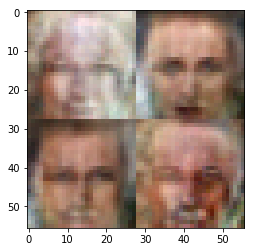

Epoch 1/1... Discriminator Loss: 1.3053... Generator Loss: 0.6161


Epoch 1/1... Discriminator Loss: 0.7974... Generator Loss: 4.0595


Epoch 1/1... Discriminator Loss: 0.9825... Generator Loss: 1.9252


Epoch 1/1... Discriminator Loss: 0.8682... Generator Loss: 1.3955


Epoch 1/1... Discriminator Loss: 0.8624... Generator Loss: 1.7460


Epoch 1/1... Discriminator Loss: 0.7964... Generator Loss: 2.1028


Epoch 1/1... Discriminator Loss: 0.9393... Generator Loss: 1.5128


Epoch 1/1... Discriminator Loss: 0.6033... Generator Loss: 4.8376


Epoch 1/1... Discriminator Loss: 0.7863... Generator Loss: 1.9642


Epoch 1/1... Discriminator Loss: 1.0156... Generator Loss: 1.1664


Epoch 1/1... Discriminator Loss: 0.8275... Generator Loss: 2.3448


Epoch 1/1... Discriminator Loss: 0.4986... Generator Loss: 2.4780


Epoch 1/1... Discriminator Loss: 1.7662... Generator Loss: 0.6041


Epoch 1/1... Discriminator Loss: 0.8386... Generator Loss: 1.5747


Epoch 1/1... Discriminator Loss: 0.6550... Generator Loss: 3.2193


Epoch 1/1... Discriminator Loss: 0.9526... Generator Loss: 3.9365


Epoch 1/1... Discriminator Loss: 1.0913... Generator Loss: 1.2069


Epoch 1/1... Discriminator Loss: 0.6529... Generator Loss: 2.4666


Epoch 1/1... Discriminator Loss: 0.9079... Generator Loss: 1.4912


Epoch 1/1... Discriminator Loss: 0.9250... Generator Loss: 1.5545


Epoch 1/1... Discriminator Loss: 0.8453... Generator Loss: 3.1056


Epoch 1/1... Discriminator Loss: 0.7405... Generator Loss: 4.0506


Epoch 1/1... Discriminator Loss: 0.7495... Generator Loss: 3.5728


Epoch 1/1... Discriminator Loss: 1.1271... Generator Loss: 1.4467


Epoch 1/1... Discriminator Loss: 0.7807... Generator Loss: 2.2405


Epoch 1/1... Discriminator Loss: 0.7711... Generator Loss: 2.1726


Epoch 1/1... Discriminator Loss: 0.8171... Generator Loss: 2.0493


Epoch 1/1... Discriminator Loss: 0.6449... Generator Loss: 1.4348


Epoch 1/1... Discriminator Loss: 0.6360... Generator Loss: 3.9366


Epoch 1/1... Discriminator Loss: 0.6953... Generator Loss: 3.0822


Epoch 1/1... Discriminator Loss: 1.0647... Generator Loss: 1.0225


Epoch 1/1... Discriminator Loss: 1.3348... Generator Loss: 3.1221


Epoch 1/1... Discriminator Loss: 0.7708... Generator Loss: 2.4827


Epoch 1/1... Discriminator Loss: 0.9336... Generator Loss: 1.9495


Epoch 1/1... Discriminator Loss: 0.5276... Generator Loss: 2.6202


Epoch 1/1... Discriminator Loss: 1.0387... Generator Loss: 0.6783


Epoch 1/1... Discriminator Loss: 0.7246... Generator Loss: 2.5202


Epoch 1/1... Discriminator Loss: 0.7688... Generator Loss: 2.8408


Epoch 1/1... Discriminator Loss: 1.0402... Generator Loss: 1.0604


Epoch 1/1... Discriminator Loss: 0.7918... Generator Loss: 2.6821


Epoch 1/1... Discriminator Loss: 0.8940... Generator Loss: 1.7040


Epoch 1/1... Discriminator Loss: 0.8536... Generator Loss: 1.3125


Epoch 1/1... Discriminator Loss: 0.8891... Generator Loss: 1.8774


Epoch 1/1... Discriminator Loss: 0.8821... Generator Loss: 1.9302


Epoch 1/1... Discriminator Loss: 1.0716... Generator Loss: 2.2637


Epoch 1/1... Discriminator Loss: 0.8880... Generator Loss: 1.4838


Epoch 1/1... Discriminator Loss: 0.6790... Generator Loss: 3.3967


Epoch 1/1... Discriminator Loss: 0.8533... Generator Loss: 1.4468


Epoch 1/1... Discriminator Loss: 1.2016... Generator Loss: 0.8618


Epoch 1/1... Discriminator Loss: 0.8968... Generator Loss: 1.6759


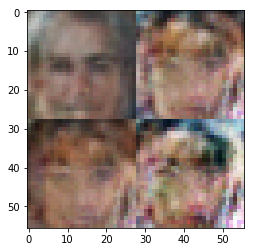

Epoch 1/1... Discriminator Loss: 0.7389... Generator Loss: 2.8720


Epoch 1/1... Discriminator Loss: 0.8796... Generator Loss: 1.3460


Epoch 1/1... Discriminator Loss: 0.8714... Generator Loss: 1.5604


Epoch 1/1... Discriminator Loss: 0.9441... Generator Loss: 1.3397


Epoch 1/1... Discriminator Loss: 0.7328... Generator Loss: 2.5946


Epoch 1/1... Discriminator Loss: 1.1119... Generator Loss: 1.9696


Epoch 1/1... Discriminator Loss: 0.5938... Generator Loss: 6.2460


Epoch 1/1... Discriminator Loss: 1.3516... Generator Loss: 0.8645


Epoch 1/1... Discriminator Loss: 0.5068... Generator Loss: 4.4139


Epoch 1/1... Discriminator Loss: 1.0208... Generator Loss: 1.5010


Epoch 1/1... Discriminator Loss: 0.7087... Generator Loss: 3.1885


Epoch 1/1... Discriminator Loss: 0.9459... Generator Loss: 1.2323


Epoch 1/1... Discriminator Loss: 0.8861... Generator Loss: 1.6320


Epoch 1/1... Discriminator Loss: 0.8912... Generator Loss: 1.4163


Epoch 1/1... Discriminator Loss: 0.8979... Generator Loss: 2.3888


Epoch 1/1... Discriminator Loss: 1.1115... Generator Loss: 1.3130


Epoch 1/1... Discriminator Loss: 0.8625... Generator Loss: 1.9180


Epoch 1/1... Discriminator Loss: 1.0036... Generator Loss: 1.3643


Epoch 1/1... Discriminator Loss: 1.0396... Generator Loss: 1.3783


Epoch 1/1... Discriminator Loss: 0.7334... Generator Loss: 2.6996


Epoch 1/1... Discriminator Loss: 1.0512... Generator Loss: 2.4261


Epoch 1/1... Discriminator Loss: 0.5493... Generator Loss: 5.3526


Epoch 1/1... Discriminator Loss: 0.9743... Generator Loss: 2.3161


Epoch 1/1... Discriminator Loss: 0.3302... Generator Loss: 7.4946


Epoch 1/1... Discriminator Loss: 0.7044... Generator Loss: 2.0585


Epoch 1/1... Discriminator Loss: 0.8750... Generator Loss: 1.5892


Epoch 1/1... Discriminator Loss: 1.2758... Generator Loss: 0.7304


Epoch 1/1... Discriminator Loss: 0.6601... Generator Loss: 2.0539


Epoch 1/1... Discriminator Loss: 1.0616... Generator Loss: 1.1000


Epoch 1/1... Discriminator Loss: 0.7527... Generator Loss: 2.4875


Epoch 1/1... Discriminator Loss: 0.7933... Generator Loss: 2.3560


Epoch 1/1... Discriminator Loss: 0.8436... Generator Loss: 2.3688


Epoch 1/1... Discriminator Loss: 0.9453... Generator Loss: 0.8385


Epoch 1/1... Discriminator Loss: 0.8048... Generator Loss: 2.1217


Epoch 1/1... Discriminator Loss: 1.0178... Generator Loss: 1.5116


Epoch 1/1... Discriminator Loss: 1.0223... Generator Loss: 1.2737


Epoch 1/1... Discriminator Loss: 0.7801... Generator Loss: 2.4763


Epoch 1/1... Discriminator Loss: 0.9058... Generator Loss: 3.3141


Epoch 1/1... Discriminator Loss: 1.5296... Generator Loss: 1.9605


Epoch 1/1... Discriminator Loss: 1.0055... Generator Loss: 1.1554


In [ ]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.